In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking, GRU
import numpy as np
import keras
#from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from numpy import load
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K


np.random.seed(1337)# setting the random seed value

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/train_data/ILDC_multi.csv') # loading dataset

In [ ]:
# path to transformer generated chunk embeddings
path_transformer_chunk_embeddings_train = '/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/LSGBERT_npy_files_cls_multi_full/LSGBERT_cls_train.npy'
path_transformer_chunk_embeddings_dev = '/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/LSGBERT_npy_files_cls_multi_full/LSGBERT_cls_dev.npy'
path_transformer_chunk_embeddings_test = '/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/LSGBERT_npy_files_cls_multi_full/LSGBERT_cls_test.npy'

In [ ]:
# loading the chunk embeddings
x_train0 = load(path_transformer_chunk_embeddings_train, allow_pickle = True)
x_dev0 = load(path_transformer_chunk_embeddings_dev, allow_pickle= True)
x_test0 = load(path_transformer_chunk_embeddings_test, allow_pickle= True)

In [ ]:
l=[]
for i in range(len(x_test0)):
  l.append(len(x_test0[i]))

In [ ]:
print(l)

[7, 5, 9, 11, 12, 13, 11, 8, 25, 17, 25, 3, 4, 8, 11, 6, 10, 16, 14, 15, 13, 9, 4, 22, 25, 7, 13, 25, 14, 13, 25, 17, 12, 3, 10, 13, 9, 11, 14, 5, 15, 18, 9, 13, 15, 17, 7, 4, 8, 12, 7, 5, 17, 5, 25, 5, 14, 10, 8, 11, 16, 7, 8, 15, 18, 15, 25, 25, 14, 1, 25, 16, 17, 5, 4, 25, 5, 7, 14, 11, 9, 2, 15, 14, 7, 9, 9, 18, 23, 9, 24, 17, 6, 6, 5, 8, 13, 6, 4, 8, 13, 12, 13, 16, 20, 24, 12, 12, 25, 15, 25, 5, 16, 6, 6, 21, 10, 25, 14, 18, 16, 7, 10, 22, 22, 5, 21, 9, 7, 13, 3, 8, 19, 13, 7, 11, 20, 10, 10, 4, 19, 8, 12, 25, 11, 25, 14, 12, 20, 6, 9, 9, 8, 25, 2, 3, 7, 6, 6, 3, 14, 12, 25, 4, 6, 9, 4, 4, 25, 13, 3, 12, 10, 9, 5, 20, 9, 6, 7, 7, 9, 6, 9, 8, 6, 13, 7, 9, 18, 19, 6, 9, 12, 6, 22, 7, 16, 18, 7, 6, 9, 8, 9, 25, 10, 25, 11, 12, 3, 6, 13, 7, 25, 5, 11, 9, 11, 9, 6, 4, 2, 4, 25, 3, 6, 2, 13, 8, 8, 7, 6, 12, 25, 9, 5, 11, 10, 7, 21, 9, 20, 4, 19, 12, 5, 3, 7, 25, 7, 4, 6, 9, 9, 9, 25, 8, 7, 23, 7, 5, 10, 11, 3, 16, 9, 25, 9, 11, 8, 8, 10, 14, 11, 13, 12, 25, 15, 5, 25, 7, 14, 25, 4, 11,

In [ ]:
l[:] = list(set(l))

In [ ]:
print(l)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [ ]:
# loading the corresponding label for each case in dataset
dev = dataset.loc[dataset['split'] == 'dev']
train = dataset.loc[dataset['split'] == 'train']
test = dataset.loc[dataset['split'] == 'test']

y_train0 = []
for i in range(train.shape[0]):
    y_train0.append(train.loc[i,'label'])

y_dev0 = []
for i in range(dev.shape[0]):
    y_dev0.append(dev.loc[i+32305,'label'])

y_test0 = []
for i in range(test.shape[0]):
    y_test0.append(test.loc[i+33299,'label'])

In [ ]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


In [ ]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=200,return_coefficients=False,**kwargs):
        # Initializer
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def _get_attention_weights(self, X):

        u_tw = K.tanh(K.dot(X, self.W))
        tw_stimulus = K.dot(u_tw, self.u)

        # Remove the last axis an apply softmax to the stimulus to
        # get a probability.
        tw_stimulus = K.squeeze(tw_stimulus, -1)
        tw_stimulus = K.exp(tw_stimulus)


        tw_stimulus /= K.cast(K.sum(tw_stimulus, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        att_weights = K.expand_dims(tw_stimulus)
        return att_weights

    def call(self, hit, mask=None):
        att_weights = self._get_attention_weights(hit)

        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait

        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):

        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
from keras import layers
# Input layer to convert into required tensor shape
text_input = Input(shape=(None,768,), dtype='float32', name='text')
# Masking layer to mask the padded values
l_mask = layers.Masking(mask_value=-99.)(text_input)
# After masking we encoded the vector using 2 bidirectional GRU's
encoded_text = layers.Bidirectional(GRU(100,return_sequences=True))(l_mask)
encoded_text1 = layers.Bidirectional(GRU(100,return_sequences=True))(encoded_text)
# Then we add the Attention Layer which we created above
sent_att,sent_coeffs, = AttentionLayer(200,return_coefficients=True,name='sent_attention')(encoded_text1)
# Add a dropout layer
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
# Added a dense layer after encoding
out1 = layers.Dense(30, activation='relu')(sent_drop)
# And we add a sigmoid classifier on top
out = layers.Dense(1, activation='sigmoid')(out1)
model = Model(text_input,out)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking (Masking)           (None, None, 768)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 200)         522000    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 200)         181200    
 onal)                                                           
                                                                 
 sent_attention (AttentionL  [(None, 200),             40400     
 ayer)                        (None, None, 1)]                   
                                                             

In [ ]:
num_sequences = len(x_train0)
batch_size = 32
batches_per_epoch =  int(num_sequences/batch_size)
num_features= 768
def train_generator(): # function to generate batches of corresponding batch size
    x_list= x_train0
    y_list =  y_train0
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(x_train0[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole training data
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(x_dev0)
batch_size_val = 32
batches_per_epoch_val = int(num_sequences_val/batch_size_val)
num_features= 768
def val_generator(): # Similar function to generate validation batches
    x_list= x_dev0
    y_list =  y_dev0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(x_dev0[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole validation data
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
# compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Setting the callback and training the model
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=2, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

model.fit_generator(train_generator(), steps_per_epoch=batches_per_epoch, epochs=2,
                    validation_data=val_generator(), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/2


<ipython-input-17-d54a78899f6a>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator(), steps_per_epoch=batches_per_epoch, epochs=2,


1009/1009 [==============================] - 52s 33ms/step - loss: 0.3638 - acc: 0.8437 - val_loss: 0.4462 - val_acc: 0.8085 - lr: 0.0010
Epoch 2/2
1009/1009 [==============================] - 28s 27ms/step - loss: 0.3439 - acc: 0.8541 - val_loss: 0.4432 - val_acc: 0.8175 - lr: 0.0010


In [ ]:
num_sequences_test = len(x_test0)
batch_size_test = 32
batches_per_epoch_test = int(num_sequences_test/batch_size_test) + 1
num_features= 768
def test_generator(): # function to generate batches of corresponding batch size
    x_list= x_test0
    y_list =  y_test0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_test):
            if(b == batches_per_epoch_test-1): # An extra if else statement just to manage the last batch as it's size might not be equal to batch size
              longest_index = num_sequences_test - 1
              timesteps = len(max(x_test0[:longest_index + 1][-batch_size_test:], key=len))
              x_train = np.full((longest_index - b*batch_size_test, timesteps, num_features), -99.)
              y_train = np.zeros((longest_index - b*batch_size_test,  1))
              for i in range(longest_index - b*batch_size_test):
                  li = b * batch_size_test + i
                  x_train[i, 0:len(x_list[li]), :] = x_list[li]
                  y_train[i] = y_list[li]
            else:
                longest_index = (b + 1) * batch_size_test - 1
                timesteps = len(max(x_test0[:(b + 1) * batch_size_test][-batch_size_test:], key=len))
                x_train = np.full((batch_size_test, timesteps, num_features), -99.)
                y_train = np.zeros((batch_size_test,  1))
                # padding the vectors with respect to the maximum sequence of each batch and not the whole test data
                for i in range(batch_size_test):
                    li = b * batch_size_test + i
                    x_train[i, 0:len(x_list[li]), :] = x_list[li]
                    y_train[i] = y_list[li]
            yield x_train, y_train


In [ ]:
# evaluating on the test data
model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)

<ipython-input-19-8e91bbf97f2e>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)


[0.4364958107471466, 0.8139841556549072]

In [ ]:
# defining a function which calculates various metrics such as micro and macro precision, accuracy and f1
def metrics_calculator(preds, test_labels):
    cm = confusion_matrix(test_labels, preds)
    TP = []
    FP = []
    FN = []
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[i][j]

        FN.append(summ)
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[j][i]

        FP.append(summ)
    for i in range(0,2):
        TP.append(cm[i][i])
    precision = []
    recall = []
    for i in range(0,2):
        precision.append(TP[i]/(TP[i] + FP[i]))
        recall.append(TP[i]/(TP[i] + FN[i]))

    macro_precision = sum(precision)/2
    macro_recall = sum(recall)/2
    micro_precision = sum(TP)/(sum(TP) + sum(FP))
    micro_recall = sum(TP)/(sum(TP) + sum(FN))
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)
    return macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1

In [ ]:
# getting the predicted labels on the test data
preds = model.predict_generator(test_generator(), steps= batches_per_epoch_test)
y_pred = preds > 0.5

# Calculating all metrics on test data predicted label
print(metrics_calculator(y_pred, y_test0[:-1]))

<ipython-input-21-129cc16c0af6>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator(), steps= batches_per_epoch_test)


(0.8141704826317706, 0.8139342621681127, 0.8140523552634191, 0.8139841688654353, 0.8139841688654353, 0.8139841688654353)


In [ ]:
#model.evaluate(val_generator(), steps= batches_per_epoch_val)

In [ ]:
# getting the predicted labels on the dev data
preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)
y_pred_dev = preds > 0.5

# Calculating all metrics on dev data predicted label
print(metrics_calculator(y_pred_dev, y_dev0[:-2]))

<ipython-input-23-1a0ce2dc0e38>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)


(0.8182245903041709, 0.8175403225806451, 0.8178823133221119, 0.8175403225806451, 0.8175403225806451, 0.817540322580645)


In [ ]:
# saving the trained model
#model.save('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/BIGRU_Attention_LSGBERT_full.h5')  # creates a HDF5 file 'BIGRU_Attention_XLNet.h5'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# getting the self attention layer from the trained model and creating a new model with that layer to get attention weights
att_layer = model.get_layer('sent_attention') #  recupera lo strato di autoattenzione chiamato 'sent_attention' dal modello esistente
prev_tensor = att_layer.input #  viene ottenuto il tensore di input dell'autoattenzione att_layer, rappresenta i dati di input dell'autoattenzione.

#Qui viene creato uno strato dummy (fittizio) utilizzando Lambda per calcolare i pesi di attenzione dell'autoattenzione. La funzione lambda prende
# il tensore prev_tensor come input e richiama il metodo _get_attention_weights dell'autoattenzione (att_layer) per ottenere i pesi di attenzione.
dummy_layer = Lambda(lambda x: att_layer._get_attention_weights(x))(prev_tensor)

# viene creato un nuovo modello chiamato model2. text_input è un tensore che rappresenta i dati di input del modello originale, dummy_layer è lo strato
# dummy creato nella riga precedente, che restituisce i pesi di attenzione. In questo modo, model2 è stato costruito per accettare lo stesso input del
# modello originale ma produce un output che sono i pesi di attenzione calcolati dall'autoattenzione.
model2 = Model(text_input, dummy_layer)
model2.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'sent_attention/W:0' shape=(200, 200) dtype=float32>
  <tf.Variable 'sent_attention/u:0' shape=(200, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking (Masking)           (None, None, 768)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 200)         522000    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 200)         181200    
 onal)                                                           
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 703200 (2.68 MB)
Trainable params: 703200 (2.

In [ ]:
# splitting test data depending on chunk length
x_chunks = []*25  #conterrà  sottoliste corrispondenti ai  possibili valori di lunghezza dei chunk.
for i in range(25):
  x_chunks.append([]) #  utilizzato un ciclo for per popolare la lista x_chunks con altre 25 liste vuote.
#In pratica, viene creata una lista di liste, ognuna delle quali rappresenta un gruppo di chunk di una determinata lunghezza.

'''
x_test0 è una variabile che rappresenta i dati di input per il modello di apprendimento automatico. In particolare, x_test0
contiene i "chunk" (o segmenti) di testo che verranno utilizzati per valutare le prestazioni del modello sulla fase di test.
è una lista di vettori numpy (array multidimensionali) che rappresentano i chunk di testo. Ogni elemento della lista è un
vettore numpy che codifica un "chunk" di testo. La struttura e la dimensione esatta dei vettori dipendono dalle caratteristiche
specifiche dell'applicazione e del modello utilizzato. Nel codice, si fa riferimento al valore 768 come numero di "features"
per ciascun "chunk". Ogni vettore_chunk_i contiene i dati di input per il modello relativi al chunk i-esimo.
Utilizzando x_test0, il modello fa previsioni su ciascun "chunk" di testo e valuta la sua accuratezza o altre metriche di prestazione.


Viene eseguito un altro ciclo for per scorrere i dati di test (x_test0) e suddividerli in base alla loro lunghezza.
Viene preso il singolo chunk e viene determinata la sua lunghezza con len(x_test0[i]). Questa lunghezza viene utilizzata
per ottenere l'indice appropriato all'interno della lista x_chunks, in modo da inserire il chunk nella sottolista corrispondente.

Ad esempio, se il primo chunk ha una lunghezza di 10, verrà inserito nella lista x_chunks[9] (l'indice 9 rappresenta lunghezza 10 - 1).
In questo modo, alla fine dell'esecuzione del codice, x_chunks conterrà 25 sottoliste, ognuna delle quali contiene i chunk di test con la stessa lunghezza.
'''

for i in range(len(x_test0)):
  x_chunks[len(x_test0[i]) - 1].append(x_test0[i])

In [ ]:
tot=0
for i in range(len(x_chunks)):
  print(f'IL CHUNK DI LUNGHEZZA {i+1} è FORMATO DA {len(x_chunks[i])} DOCUMENTI')
  tot =tot + len(x_chunks[i])
  print(f'TUTTI QUANTI DI LUNGHEZZA {len(x_chunks[i][0])}')
  print(f'OGNI SINGOLO ARRAY HA DIMENSIONE {len(x_chunks[i][0][0])}')
  print('--------------------------------------------------------')
print(f'IL NUMERO TOTALE DI DOCUMENTI NEL TEST è {tot}')

IL CHUNK DI LUNGHEZZA 1 è FORMATO DA 20 DOCUMENTI
TUTTI QUANTI DI LUNGHEZZA 1
OGNI SINGOLO ARRAY HA DIMENSIONE 768
--------------------------------------------------------
IL CHUNK DI LUNGHEZZA 2 è FORMATO DA 32 DOCUMENTI
TUTTI QUANTI DI LUNGHEZZA 2
OGNI SINGOLO ARRAY HA DIMENSIONE 768
--------------------------------------------------------
IL CHUNK DI LUNGHEZZA 3 è FORMATO DA 71 DOCUMENTI
TUTTI QUANTI DI LUNGHEZZA 3
OGNI SINGOLO ARRAY HA DIMENSIONE 768
--------------------------------------------------------
IL CHUNK DI LUNGHEZZA 4 è FORMATO DA 80 DOCUMENTI
TUTTI QUANTI DI LUNGHEZZA 4
OGNI SINGOLO ARRAY HA DIMENSIONE 768
--------------------------------------------------------
IL CHUNK DI LUNGHEZZA 5 è FORMATO DA 132 DOCUMENTI
TUTTI QUANTI DI LUNGHEZZA 5
OGNI SINGOLO ARRAY HA DIMENSIONE 768
--------------------------------------------------------
IL CHUNK DI LUNGHEZZA 6 è FORMATO DA 119 DOCUMENTI
TUTTI QUANTI DI LUNGHEZZA 6
OGNI SINGOLO ARRAY HA DIMENSIONE 768
-----------------------

In [ ]:
#model2.save('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/BIGRU_Attention_LSGBERT_full_model2.h5')  # creates a HDF5 file 'BIGRU_Attention_XLNet.h5'


In [ ]:
# getting attention weights for each chunk and finding the mean over all data for a particular chunk length
wt_vector = []*25 # creo un elenco vuoto chiamato wt_vector, che conterrà i pesi di attenzione calcolati per ogni "chunk" di testo per ciascuna lunghezza.
wt_total = []*25 #  creo un altro elenco vuoto chiamato wt_total, che conterrà la media dei pesi di attenzione per tutti i "chunk" di una particolare lunghezza.

for chunk_length in range(25): # Viene eseguito un ciclo for sulla lunghezza dei chunk chunk_length, da 0 a 24 (poiché il massimo numero di chunk è 25).
  wt_vector.append([]) # All'interno del primo ciclo for, vengono aggiunti due elementi vuoti all'elenco wt_vector
  wt_total.append(0) # e viene aggiunto un valore iniziale di 0 all'elenco wt_total per la lunghezza corrente.
  for i in range(len(x_chunks[chunk_length])): # Viene eseguito un secondo ciclo for su tutti i chunk di testo della lunghezza corrente (x_chunks[chunk_length]), cioè su tutti i chunk di testo della lunghezza chunk_length.
     curr = x_chunks[chunk_length][i] #  questa riga estrae un "chunk" di testo specifico dalla lista x_chunks e lo assegna alla variabile curr.
     curr = curr.reshape((1, len(curr), 768)) # Questa riga ridimensiona (reshape) il vettore numpy curr in una nuova forma specifica. La nuova forma sarà una matrice con 3 dimensioni: 1 riga, len(curr) colonne e 768 canali.
     '''
     In particolare:
     - 1 rappresenta il numero di campioni (o istanze) di dati in questo caso. In pratica, viene creato un nuovo batch di dati contenente un singolo "chunk" di testo.
     Questo è spesso richiesto per passare i dati come input a modelli di apprendimento automatico che accettano i dati in formato batch.
     - len(curr) rappresenta il numero di passi temporali (o lunghezza) del "chunk" di testo. La lunghezza del "chunk" può variare a seconda del testo,
     quindi è necessario adattare il numero di passi temporali in modo da adattarsi al modello.
     - 768 rappresenta il numero di features (caratteristiche) per ogni passo temporale del "chunk". In questo caso specifico, sembra che ogni "chunk" di testo
     abbia 768 features, come specificato nel codice.
     '''

     wt_vector[chunk_length].append(model2.predict(curr)) # Il valore di attenzione calcolato per ciascun "chunk" viene aggiunto all'elenco wt_vector corrispondente alla lunghezza del chunk.
     wt_total[chunk_length] +=wt_vector[chunk_length][i] # Vengono aggiornati i pesi totali (wt_total[chunk_length]) sommando tutti i valori di attenzione calcolati per ciascun "chunk" della stessa lunghezza.
  wt_total[chunk_length] /= len(wt_vector[chunk_length]) # Dopo aver calcolato la somma dei pesi di attenzione per tutti i chunk di testo della stessa lunghezza, viene calcolata la media dividendo per il numero di "chunk" considerati. In questo caso, len(wt_vector[chunk_length]) rappresenta il numero di "chunk" di testo della lunghezza corrente.
  '''
  Vengono ridotti gli assi dell'elenco wt_total[chunk_length] per ottenere un vettore più semplice rappresentante la media dei pesi di attenzione per tutti i "chunk" di testo della lunghezza corrente.
  La riduzione degli assi viene effettuata due volte utilizzando np.squeeze() per rimuovere eventuali dimensioni che hanno valore 1.
  '''
  wt_total[chunk_length] = np.squeeze(wt_total[chunk_length], axis = 0)
  wt_total[chunk_length] = np.squeeze(wt_total[chunk_length], axis = 1)
'''
l'elenco wt_total conterrà la media dei pesi di attenzione calcolati per tutti i "chunk" di testo per ciascuna lunghezza.
Questi pesi possono essere utilizzati per analizzare l'importanza relativa di ciascun "chunk" di testo durante il processo di elaborazione e valutazione del modello.
'''

1/1 [==============================] - 0s 37ms/step


'\nl\'elenco wt_total conterrà la media dei pesi di attenzione calcolati per tutti i "chunk" di testo per ciascuna lunghezza.\nQuesti pesi possono essere utilizzati per analizzare l\'importanza relativa di ciascun "chunk" di testo durante il processo di elaborazione e valutazione del modello.\n'

In [ ]:
import pickle
file_path = '/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/att_wt_of_LSGBERT_bigru_full.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(wt_vector, file)

In [ ]:
with open(file_path, 'rb') as file:
    wt_vector = pickle.load(file)

In [ ]:
len(wt_vector)

25

In [ ]:
wt_vector

[[array([[[0.99999905]]], dtype=float32),
  array([[[0.9999978]]], dtype=float32),
  array([[[1.]]], dtype=float32),
  array([[[0.9999959]]], dtype=float32),
  array([[[0.9999999]]], dtype=float32),
  array([[[0.9999939]]], dtype=float32),
  array([[[0.99987143]]], dtype=float32),
  array([[[0.99997157]]], dtype=float32),
  array([[[0.9999676]]], dtype=float32),
  array([[[0.99988467]]], dtype=float32),
  array([[[0.99999976]]], dtype=float32),
  array([[[0.99999267]]], dtype=float32),
  array([[[0.9999993]]], dtype=float32),
  array([[[0.9999517]]], dtype=float32),
  array([[[0.9999603]]], dtype=float32),
  array([[[0.9999629]]], dtype=float32),
  array([[[0.999992]]], dtype=float32),
  array([[[0.99993116]]], dtype=float32),
  array([[[1.]]], dtype=float32),
  array([[[0.9999998]]], dtype=float32)],
 [array([[[2.4448134e-04],
          [9.9975550e-01]]], dtype=float32),
  array([[[0.0484212],
          [0.9514853]]], dtype=float32),
  array([[[0.0093815 ],
          [0.99058944]]], d

In [ ]:
count = 0
for i in range(len(wt_vector)):
  print(f'CHUNK LENGHT {i} (NUM. OF DOCS {len(wt_vector[i])})')
  for j in range(len(wt_vector[i])):
    arr = wt_vector[i][j]
    index_max = np.argmax(arr)
    x = index_max
    if index_max == i:
      print(f'The most representative chunk has index: {index_max}')
    else:
      print(f'The most representative chunk has index: {index_max}      NOT LAST')
      count += 1
  print('-------------------------------------------------------------------')

print(f'NOT LAST (TOTAL) {count} OVER 1517 DOCS')
print(f'{round((count/1517)*100, 2)}%')

CHUNK LENGHT 0 (NUM. OF DOCS 20)
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
The most representative chunk has index: 0
-------------------------------------------------------------------
CHUNK LENGHT 1 (NUM. OF DOCS 32)
The mo

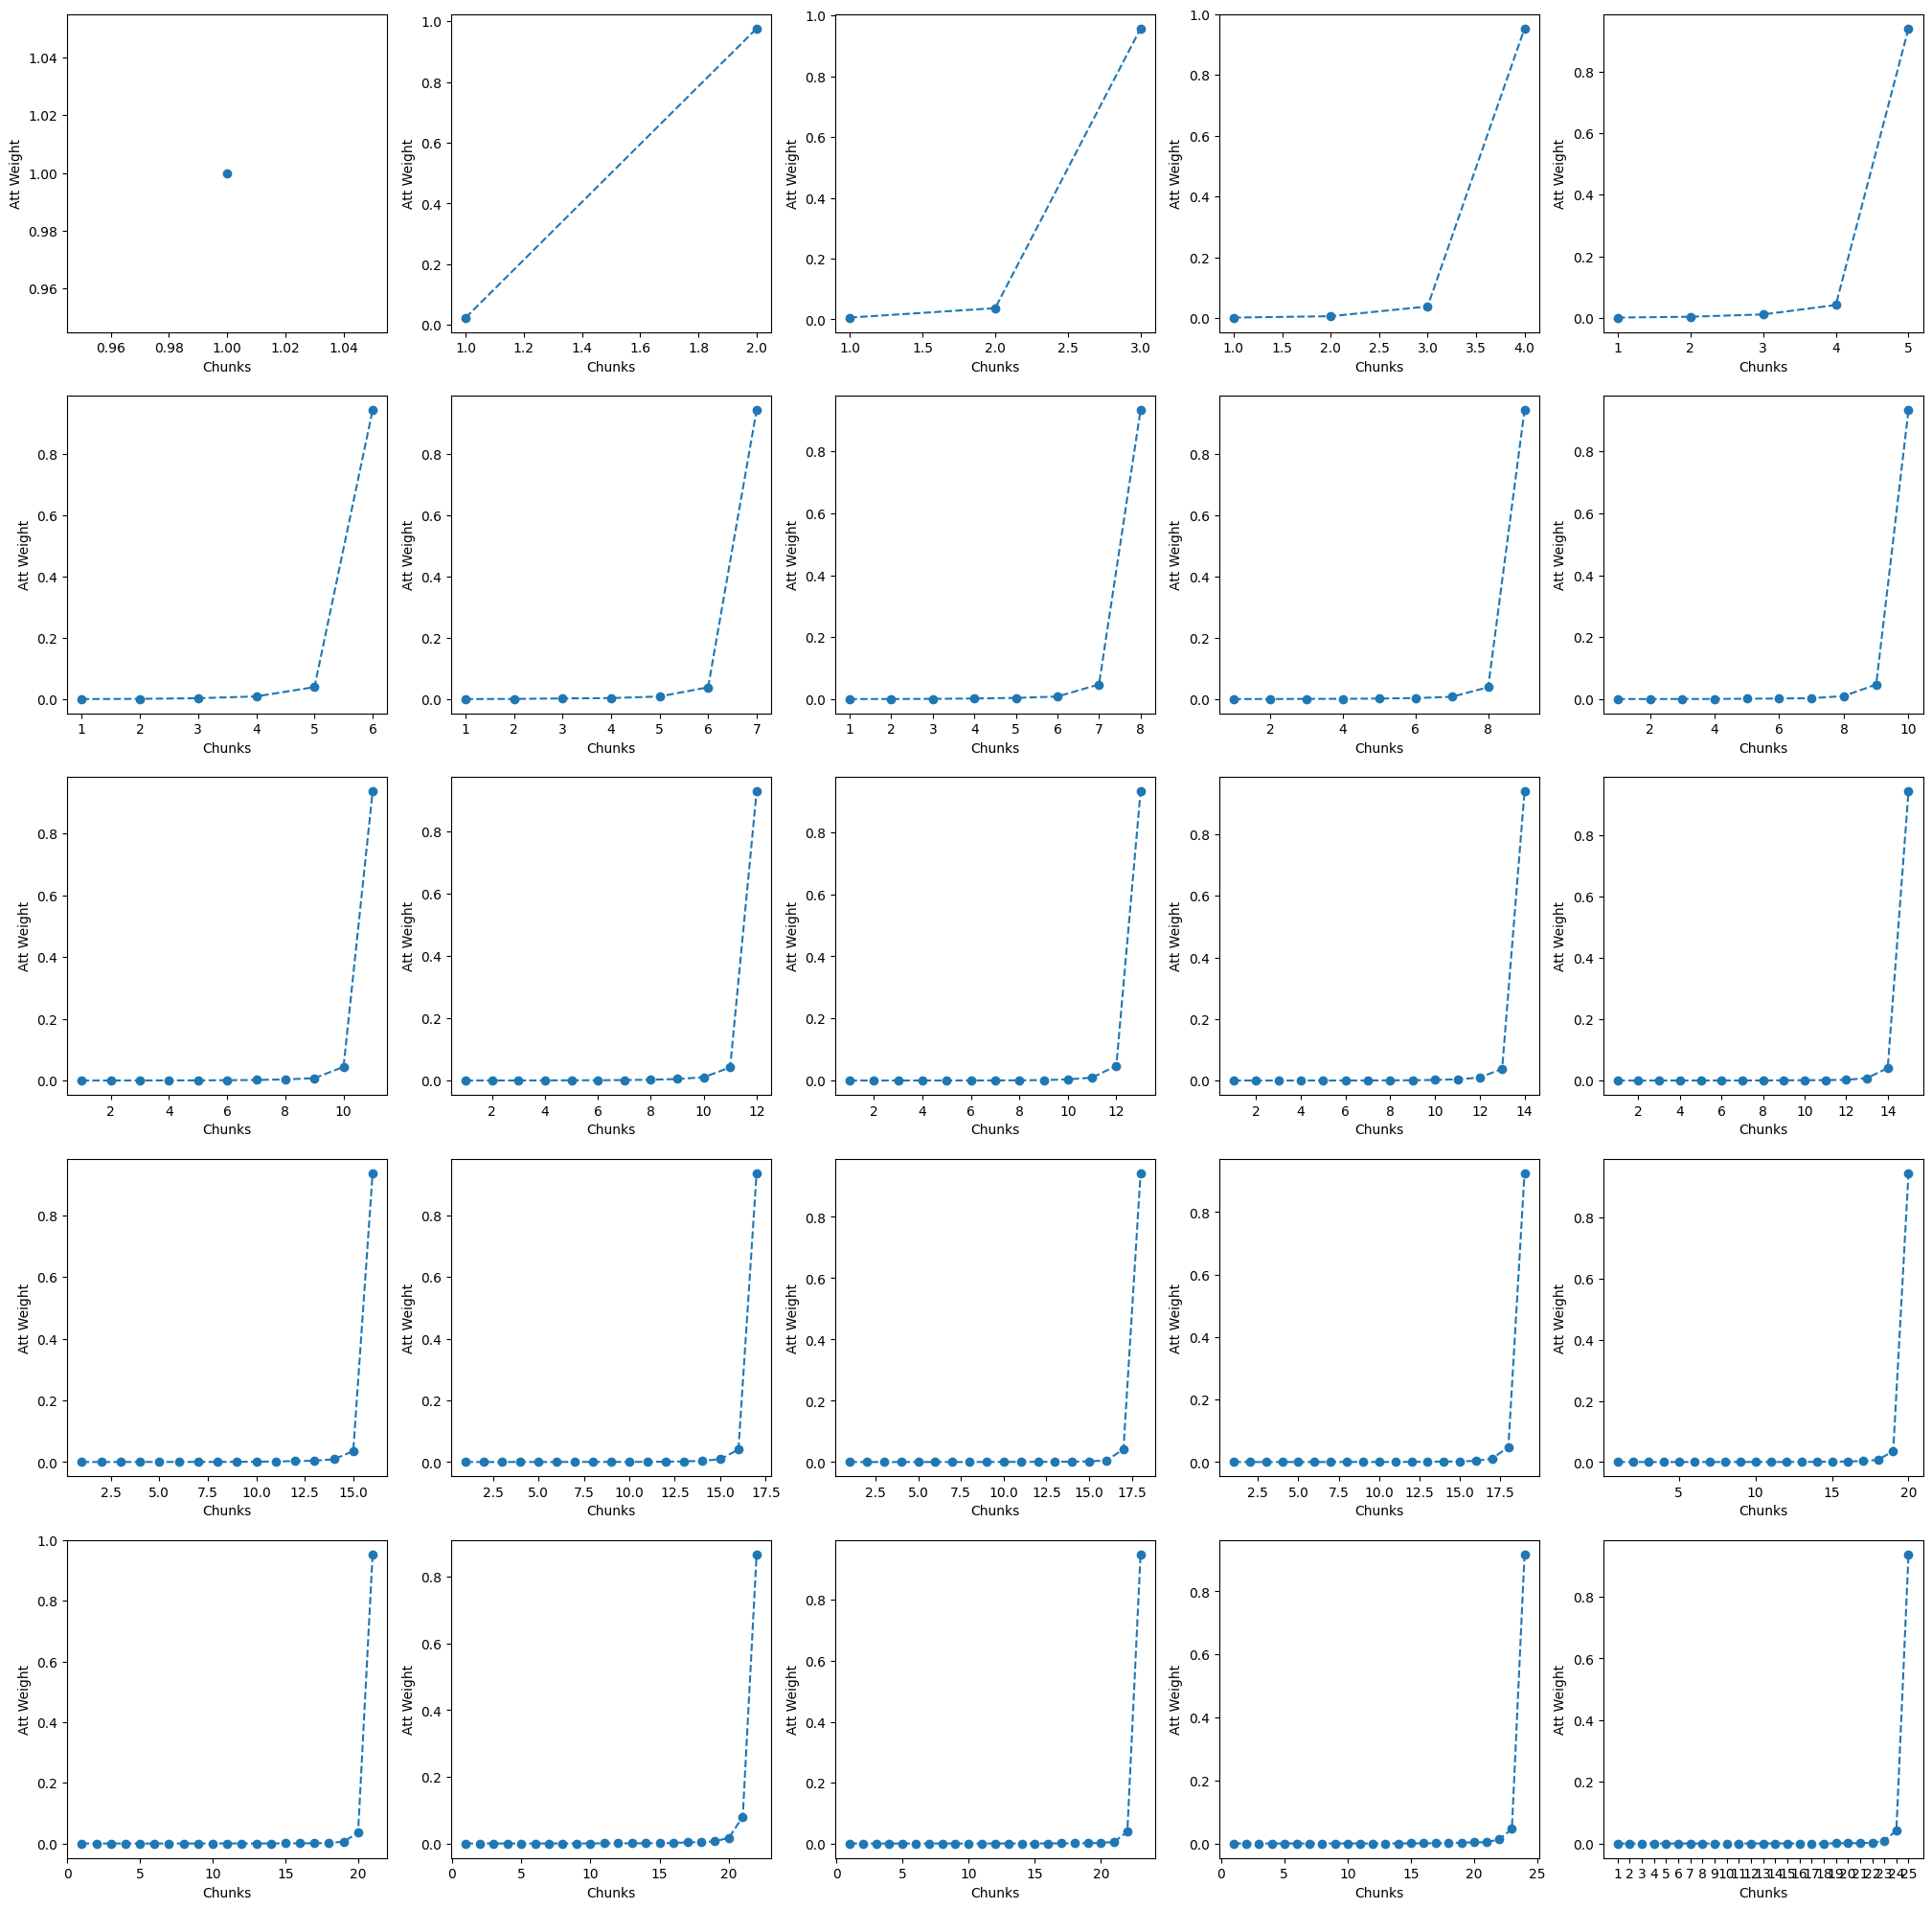

In [ ]:
import matplotlib.pyplot as plt
# plotting subplots for each chunk length( x axis: chunk size, y axis: mean attention weight)
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
num = [1]

for chunk_len in range(25):
  y = num
  plt.xticks(y)
  axs[(int)(chunk_len/5), chunk_len%5].plot(y, wt_total[chunk_len], marker = 'o', linestyle = 'dashed')
  num.append(chunk_len + 2)

for ax in axs.flat:
    ax.set(xlabel='Chunks', ylabel='Att Weight')

plt.savefig('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/attention_weights.png', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/attention_weights.eps', format='eps', bbox_inches='tight')
plt.show()


In [ ]:
# saving the mean attention weights in numpy file for future reference
data = []
for i in range(25):
  data.append(wt_total[i])

# save to npy file
#np.save('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/LSGBERT_bigru_att_full/att_wt_of_LSGBERT_bigru_full_avg.npy', data)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
